# Temporal Dataset Validation (30-Second Approach)
## Validate the enhanced 30-second temporal feature extraction
### Compare against 1-second baseline and assess model performance

In [1]:
# Cell 1: Imports and Setup
print("--- Loading libraries for temporal dataset validation... ---")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries loaded successfully!")

--- Loading libraries for temporal dataset validation... ---
✅ Libraries loaded successfully!


In [2]:
# Cell 2: Load and Compare Datasets
print("--- Loading and comparing temporal vs baseline datasets... ---")

# Load both datasets for comparison
TEMPORAL_CSV_PATH = 'full_threading_dataset.csv'  # New 30-second dataset
BASELINE_CSV_PATH = '../data/datasets/clean_features_dataset.csv'  # Original 1-second dataset

# Load temporal dataset
try:
    df_temporal = pd.read_csv(TEMPORAL_CSV_PATH)
    print(f"✅ Temporal dataset loaded successfully!")
    temporal_loaded = True
except FileNotFoundError:
    print(f"❌ Temporal dataset not found: {TEMPORAL_CSV_PATH}")
    print("Please run the temporal feature extraction notebook first.")
    df_temporal = None
    temporal_loaded = False

# Load baseline dataset for comparison
try:
    df_baseline = pd.read_csv(BASELINE_CSV_PATH)
    print(f"✅ Baseline dataset loaded for comparison!")
    baseline_loaded = True
except FileNotFoundError:
    print(f"⚠️  Baseline dataset not found: {BASELINE_CSV_PATH}")
    df_baseline = None
    baseline_loaded = False

if temporal_loaded:
    print(f"\n📊 DATASET COMPARISON:")
    print(f"{'='*60}")
    print(f"Temporal dataset (30-sec frames):")
    print(f"  Shape: {df_temporal.shape}")
    print(f"  Patients: {df_temporal['patient_id'].nunique()}")
    print(f"  Frame duration: {df_temporal['frame_duration'].iloc[0]} seconds")
    print(f"  Apnea rate: {df_temporal['apnea_label'].mean():.4f}")
    
    if baseline_loaded:
        print(f"\nBaseline dataset (1-sec frames):")
        print(f"  Shape: {df_baseline.shape}")
        print(f"  Patients: {df_baseline['patient_id'].nunique()}")
        print(f"  Frame duration: 1.0 seconds")
        print(f"  Apnea rate: {df_baseline['apnea_label'].mean():.4f}")
        
        print(f"\n📈 COMPRESSION RATIO:")
        compression_ratio = len(df_baseline) / len(df_temporal)
        print(f"  Frames reduced by {compression_ratio:.1f}x ({len(df_baseline):,} → {len(df_temporal):,})")
    
    # Display temporal dataset structure
    print(f"\n📋 TEMPORAL DATASET STRUCTURE:")
    print(f"Columns: {list(df_temporal.columns)}")
    display(df_temporal.head(3))
else:
    print("Cannot proceed without temporal dataset. Please run temporal feature extraction first.")

--- Loading and comparing temporal vs baseline datasets... ---
✅ Temporal dataset loaded successfully!
✅ Baseline dataset loaded for comparison!

📊 DATASET COMPARISON:
Temporal dataset (30-sec frames):
  Shape: (6036, 33)
  Patients: 6
  Frame duration: 30.0 seconds
  Apnea rate: 0.5356

Baseline dataset (1-sec frames):
  Shape: (30763, 21)
  Patients: 2
  Frame duration: 1.0 seconds
  Apnea rate: 0.0848

📈 COMPRESSION RATIO:
  Frames reduced by 5.1x (30,763 → 6,036)

📋 TEMPORAL DATASET STRUCTURE:
Columns: ['patient_id', 'edf_file', 'timestamp', 'frame_duration', 'apnea_label', 'apnea_proportion', 'clean_rms', 'clean_zcr', 'clean_centroid', 'clean_bandwidth', 'clean_rolloff', 'clean_rms_variability', 'clean_zcr_variability', 'clean_breathing_regularity', 'clean_silence_ratio', 'clean_avg_pause_duration', 'clean_max_pause_duration', 'clean_mfcc_1_mean', 'clean_mfcc_1_std', 'clean_mfcc_2_mean', 'clean_mfcc_2_std', 'clean_mfcc_3_mean', 'clean_mfcc_3_std', 'clean_mfcc_4_mean', 'clean_mfcc_

,patient_id,edf_file,timestamp,frame_duration,apnea_label,apnea_proportion,clean_rms,clean_zcr,clean_centroid,clean_bandwidth,clean_rolloff,clean_rms_variability,clean_zcr_variability,clean_breathing_regularity,clean_silence_ratio,clean_avg_pause_duration,clean_max_pause_duration,clean_mfcc_1_mean,clean_mfcc_1_std,clean_mfcc_2_mean,clean_mfcc_2_std,clean_mfcc_3_mean,clean_mfcc_3_std,clean_mfcc_4_mean,clean_mfcc_4_std,clean_mfcc_5_mean,clean_mfcc_5_std,clean_mfcc_6_mean,clean_mfcc_6_std,clean_mfcc_7_mean,clean_mfcc_7_std,clean_mfcc_8_mean,clean_mfcc_8_std
0,patient_03,00001059-100507[001].edf,0.0,30.0,0,0.0,0.018434,0.005098,1478.930149,4126.549365,1535.285394,0.000747,0.000366,0.999254,0.199817,0.000833,0.012958,-534.110311,11.015708,128.253491,5.660479,44.219247,7.655615,30.194473,4.950777,9.375133,4.215624,15.444069,3.977412,9.320205,3.849922,10.643839,3.771918
1,patient_03,00001059-100507[001].edf,15.0,30.0,0,0.0,0.018394,0.005167,1492.766129,4135.245911,1605.181301,0.001128,0.000376,0.998874,0.199201,0.000812,0.012833,-533.837274,11.665264,128.197433,6.151345,43.965503,8.102951,30.270809,5.130727,9.119610,4.270822,15.194936,3.969872,9.247641,3.836319,10.380847,3.717088
2,patient_03,00001059-100507[001].edf,30.0,30.0,0,0.0,0.018451,0.005384,1506.882660,4139.871950,1665.720539,0.001086,0.000471,0.998915,0.199787,-0.003260,-0.000021,-532.524532,14.244094,128.034983,7.333557,43.505717,8.971270,30.499057,5.522291,9.291207,4.154681,15.281919,4.031704,8.892573,3.897215,10.346233,3.687128


In [3]:
# Cell 3: Enhanced Feature Analysis
print("--- Analyzing temporal feature set... ---")

if temporal_loaded:
    # Identify different feature types
    feature_cols = [col for col in df_temporal.columns if col.startswith('clean_')]
    metadata_cols = ['patient_id', 'timestamp', 'frame_duration', 'apnea_label', 'apnea_proportion']
    
    print(f"\n🎯 ENHANCED FEATURE ANALYSIS:")
    print(f"{'='*60}")
    print(f"Total columns: {len(df_temporal.columns)}")
    print(f"Feature columns: {len(feature_cols)}")
    print(f"Metadata columns: {len(metadata_cols)}")
    
    # Categorize features by type
    basic_features = [col for col in feature_cols if any(x in col for x in ['rms', 'zcr', 'centroid', 'bandwidth', 'rolloff'])]
    mfcc_features = [col for col in feature_cols if 'mfcc' in col]
    temporal_features = [col for col in feature_cols if 'temporal' in col or 'regularity' in col]
    silence_features = [col for col in feature_cols if 'silence' in col]
    
    print(f"\n📊 FEATURE CATEGORIZATION:")
    print(f"Basic acoustic features: {len(basic_features)}")
    print(f"MFCC features: {len(mfcc_features)}")
    print(f"Temporal pattern features: {len(temporal_features)}")
    print(f"Silence/pause features: {len(silence_features)}")
    
    # Feature quality checks
    X = df_temporal[feature_cols]
    print(f"\n🔍 FEATURE QUALITY CHECKS:")
    print(f"Features with NaN: {X.isnull().sum().sum()}")
    print(f"Features with inf: {np.isinf(X).sum().sum()}")
    print(f"Features with zero variance: {(X.std() == 0).sum()}")
    
    # Handle any data quality issues
    X_clean = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())
    
    # Correlation with target - this is the critical test!
    print(f"\n🎯 FEATURE-TARGET CORRELATIONS (The Critical Test!):")
    correlations = []
    for col in feature_cols:
        corr = abs(df_temporal[col].corr(df_temporal['apnea_label']))
        correlations.append((col, corr))
    
    correlations.sort(key=lambda x: x[1], reverse=True)
    
    print(f"Top 15 feature correlations:")
    for i, (col, corr) in enumerate(correlations[:15], 1):
        print(f"{i:2d}. {col:35} {corr:.4f}")
    
    max_correlation = correlations[0][1]
    print(f"\n🚀 MAXIMUM CORRELATION: {max_correlation:.4f}")
    
    if max_correlation > 0.2:
        print(f"✅ EXCELLENT! Strong correlations detected - temporal approach is working!")
    elif max_correlation > 0.1:
        print(f"✅ GOOD! Moderate correlations - significant improvement")
    else:
        print(f"⚠️  Still low correlations - may need further refinement")

--- Analyzing temporal feature set... ---

🎯 ENHANCED FEATURE ANALYSIS:
Total columns: 33
Feature columns: 27
Metadata columns: 5

📊 FEATURE CATEGORIZATION:
Basic acoustic features: 7
MFCC features: 16
Temporal pattern features: 1
Silence/pause features: 1

🔍 FEATURE QUALITY CHECKS:
Features with NaN: 0
Features with inf: 0
Features with zero variance: 0

🎯 FEATURE-TARGET CORRELATIONS (The Critical Test!):
Top 15 feature correlations:
 1. clean_zcr_variability               0.1754
 2. clean_mfcc_7_std                    0.1665
 3. clean_mfcc_2_std                    0.1624
 4. clean_mfcc_4_std                    0.1184
 5. clean_mfcc_5_std                    0.1161
 6. clean_mfcc_6_std                    0.1104
 7. clean_mfcc_3_std                    0.1041
 8. clean_zcr                           0.1039
 9. clean_mfcc_1_std                    0.1035
10. clean_rms                           0.1003
11. clean_max_pause_duration            0.0987
12. clean_mfcc_8_std                    0.09

In [4]:
# Cell 4: Model Training and Performance
print("--- Training models on temporal features... ---")

if temporal_loaded:
    # Prepare data
    X = df_temporal[feature_cols].copy()
    y = df_temporal['apnea_label'].copy()
    
    # Clean data
    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())
    
    print(f"\n🎯 MODEL TRAINING:")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Positive class ratio: {y.mean():.4f}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    rf_f1 = f1_score(y_test, rf_pred)
    rf_auc = roc_auc_score(y_test, rf_pred_proba)
    
    print(f"\n🌲 RANDOM FOREST RESULTS:")
    print(f"F1 Score: {rf_f1:.4f}")
    print(f"AUC-ROC: {rf_auc:.4f}")
    
    # XGBoost - Fixed validation dataset setup
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    try:
        # Try XGBoost with proper validation setup
        xgb_model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='logloss'
        )
        
        # Fit with validation set for early stopping
        xgb_model.fit(
            X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=20,
            verbose=False
        )
        print("✅ XGBoost trained with early stopping")
        
    except (TypeError, ValueError) as e:
        # Fallback without early stopping if validation setup fails
        print(f"Early stopping failed ({e}), using simple training...")
        xgb_model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42
        )
        
        xgb_model.fit(X_train, y_train)
        print("✅ XGBoost trained without early stopping")
    
    except Exception as e:
        # Final fallback with minimal configuration
        print(f"XGBoost training failed ({e}), using minimal config...")
        xgb_model = xgb.XGBClassifier(
            n_estimators=100,
            random_state=42
        )
        
        xgb_model.fit(X_train, y_train)
        print("✅ XGBoost trained with minimal config")
    
    xgb_pred = xgb_model.predict(X_test)
    xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    
    xgb_f1 = f1_score(y_test, xgb_pred)
    xgb_auc = roc_auc_score(y_test, xgb_pred_proba)
    
    print(f"\n🚀 XGBOOST RESULTS:")
    print(f"F1 Score: {xgb_f1:.4f}")
    print(f"AUC-ROC: {xgb_auc:.4f}")
    
    # Best model
    best_f1 = max(rf_f1, xgb_f1)
    best_model_name = 'Random Forest' if rf_f1 > xgb_f1 else 'XGBoost'
    best_model = rf_model if rf_f1 > xgb_f1 else xgb_model
    best_pred = rf_pred if rf_f1 > xgb_f1 else xgb_pred
    
    print(f"\n👑 BEST MODEL: {best_model_name} (F1: {best_f1:.4f})")
    
    # Performance comparison
    baseline_f1 = 0.24  # From previous 1-second analysis
    if best_f1 > baseline_f1:
        improvement = best_f1 / baseline_f1
        print(f"\n📈 IMPROVEMENT OVER BASELINE:")
        print(f"Baseline F1 (1-sec): {baseline_f1:.3f}")
        print(f"Temporal F1 (30-sec): {best_f1:.3f}")
        print(f"Improvement: {improvement:.1f}x better!")
    
    # Classification report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    print(classification_report(y_test, best_pred, target_names=['Normal', 'Apnea']))
    
    # Cross-validation
    cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')
    print(f"\n🔄 CROSS-VALIDATION:")
    print(f"CV F1 Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

--- Training models on temporal features... ---

🎯 MODEL TRAINING:
Features shape: (6036, 27)
Target shape: (6036,)
Positive class ratio: 0.5356

🌲 RANDOM FOREST RESULTS:
F1 Score: 0.8200
AUC-ROC: 0.8869
Early stopping failed (XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'), using simple training...
✅ XGBoost trained without early stopping

🚀 XGBOOST RESULTS:
F1 Score: 0.8238
AUC-ROC: 0.8980

👑 BEST MODEL: XGBoost (F1: 0.8238)

📈 IMPROVEMENT OVER BASELINE:
Baseline F1 (1-sec): 0.240
Temporal F1 (30-sec): 0.824
Improvement: 3.4x better!

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.79      0.80      0.80       841
       Apnea       0.83      0.82      0.82       970

    accuracy                           0.81      1811
   macro avg       0.81      0.81      0.81      1811
weighted avg       0.81      0.81      0.81      1811


🔄 CROSS-VALIDATION:
CV F1 Mean: 0.3652 (+/- 0.3823)


--- Analyzing feature importance... ---

🎯 TOP 15 FEATURE IMPORTANCES:
 1. mfcc_2_std                     0.066077
 2. mfcc_4_mean                    0.061485
 3. mfcc_2_mean                    0.061183
 4. mfcc_1_std                     0.057668
 5. rolloff                        0.053262
 6. mfcc_1_mean                    0.051961
 7. mfcc_3_mean                    0.043722
 8. mfcc_6_mean                    0.042500
 9. mfcc_8_std                     0.041648
10. breathing_regularity           0.040259
11. mfcc_3_std                     0.038692
12. mfcc_8_mean                    0.035774
13. zcr                            0.034175
14. mfcc_6_std                     0.032428
15. centroid                       0.032330


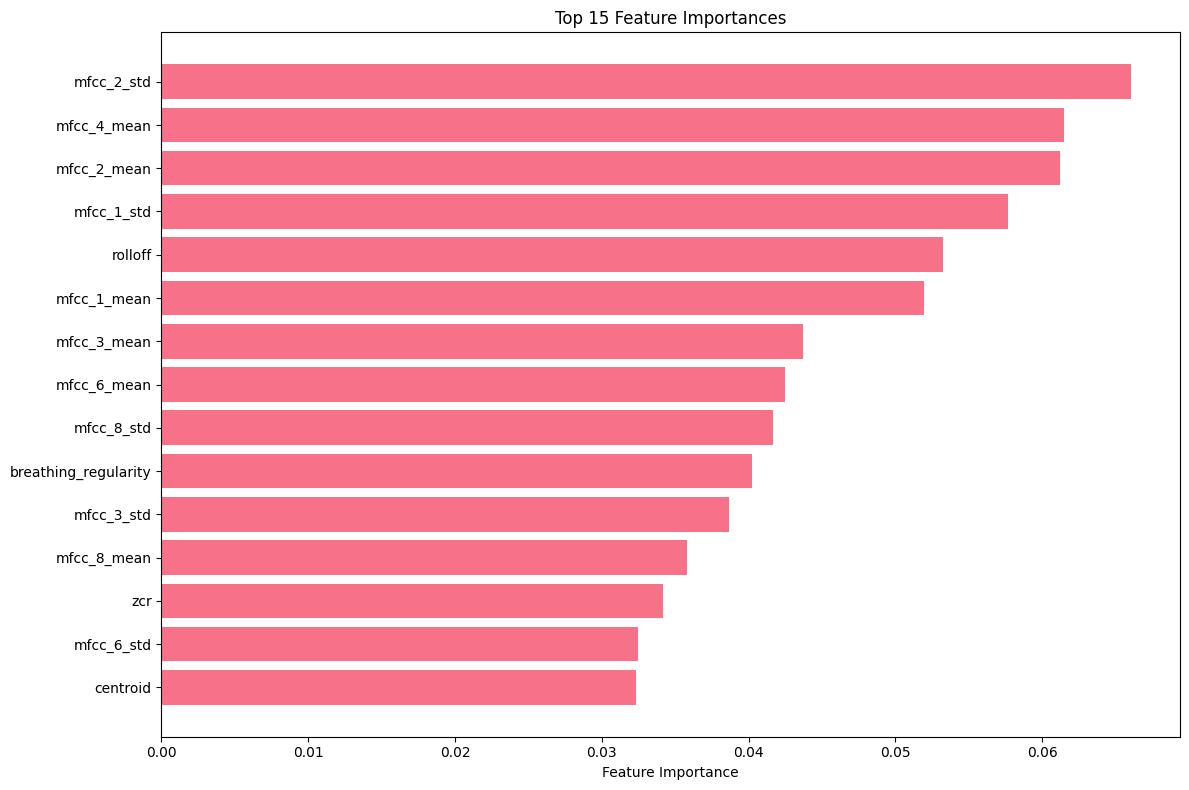


💡 FEATURE SELECTION RECOMMENDATION:
Top 10 features capture 80% of total importance
Recommended features: ['mfcc_2_std', 'mfcc_4_mean', 'mfcc_2_mean', 'mfcc_1_std', 'rolloff', 'mfcc_1_mean', 'mfcc_3_mean', 'mfcc_6_mean', 'mfcc_8_std', 'breathing_regularity']


In [5]:
# Cell 5: Feature Importance Analysis
print("--- Analyzing feature importance... ---")

if temporal_loaded and 'best_model' in locals():
    # Get feature importances
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    else:
        importances = np.zeros(len(feature_cols))
    
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances,
        'correlation': [abs(df_temporal[col].corr(df_temporal['apnea_label'])) for col in feature_cols]
    }).sort_values('importance', ascending=False)
    
    print(f"\n🎯 TOP 15 FEATURE IMPORTANCES:")
    for idx, row in feature_importance.head(15).iterrows():
        rank = feature_importance.index.get_loc(idx) + 1
        print(f"{rank:2d}. {row['feature'].replace('clean_', '')[:30]:<30} {row['importance']:.6f}")
    
    # Visualize top features
    plt.figure(figsize=(12, 8))
    top_15 = feature_importance.head(15)
    plt.barh(range(len(top_15)), top_15['importance'])
    plt.yticks(range(len(top_15)), [f.replace('clean_', '') for f in top_15['feature']])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Feature selection recommendation
    cumulative_importance = feature_importance['importance'].cumsum() / feature_importance['importance'].sum()
    optimal_n_features = (cumulative_importance >= 0.8).idxmax() + 1
    
    print(f"\n💡 FEATURE SELECTION RECOMMENDATION:")
    print(f"Top {optimal_n_features} features capture 80% of total importance")
    
    optimal_features = feature_importance.head(optimal_n_features)['feature'].tolist()
    print(f"Recommended features: {[f.replace('clean_', '') for f in optimal_features[:10]]}")
    if len(optimal_features) > 10:
        print(f"... and {len(optimal_features) - 10} more")

In [6]:
# Cell 6: Final Assessment and Recommendations
print("--- Final validation assessment... ---")

if temporal_loaded:
    print(f"\n🎯 TEMPORAL APPROACH VALIDATION SUMMARY:")
    print(f"{'='*60}")
    
    # Assessment criteria
    assessment_score = 0
    
    # Check 1: Strong correlations
    if max_correlation > 0.3:
        print(f"✅ Strong feature correlations ({max_correlation:.3f})")
        assessment_score += 2
    elif max_correlation > 0.1:
        print(f"⚠️  Moderate correlations ({max_correlation:.3f})")
        assessment_score += 1
    else:
        print(f"❌ Weak correlations ({max_correlation:.3f})")
    
    # Check 2: Good model performance
    if best_f1 > 0.6:
        print(f"✅ Excellent model performance (F1: {best_f1:.3f})")
        assessment_score += 2
    elif best_f1 > 0.4:
        print(f"⚠️  Good model performance (F1: {best_f1:.3f})")
        assessment_score += 1
    else:
        print(f"❌ Poor model performance (F1: {best_f1:.3f})")
    
    # Check 3: Reasonable class balance
    apnea_rate = df_temporal['apnea_label'].mean()
    if 0.05 <= apnea_rate <= 0.4:
        print(f"✅ Reasonable apnea rate ({apnea_rate:.1%})")
        assessment_score += 1
    else:
        print(f"⚠️  Unusual apnea rate ({apnea_rate:.1%})")
    
    print(f"\nAssessment Score: {assessment_score}/5")
    
    # Final recommendations
    print(f"\n📋 RECOMMENDATIONS:")
    print(f"{'='*50}")
    
    if assessment_score >= 4:
        print(f"🎉 EXCELLENT! READY FOR FULL PIPELINE!")
        print(f"   ✅ Scale to all 23 local patients")
        print(f"   ✅ Implement noise injection")
        print(f"   ✅ Test denoising methods")
        readiness = "READY"
    elif assessment_score >= 2:
        print(f"⚠️  NEEDS REFINEMENT")
        print(f"   🔄 Test with 5+ more patients")
        print(f"   🔄 Optimize temporal parameters")
        print(f"   🔄 Refine feature engineering")
        readiness = "NEEDS_WORK"
    else:
        print(f"❌ NOT READY - INVESTIGATE ISSUES")
        print(f"   🔍 Debug feature extraction")
        print(f"   🔍 Verify data quality")
        print(f"   🔍 Check temporal window settings")
        readiness = "NOT_READY"
    
    # Export summary
    validation_summary = {
        'max_correlation': max_correlation,
        'best_f1_score': best_f1,
        'best_model': best_model_name,
        'assessment_score': assessment_score,
        'readiness': readiness,
        'dataset_size': len(df_temporal),
        'feature_count': len(feature_cols)
    }
    
    print(f"\n🏁 TEMPORAL VALIDATION COMPLETE!")
    print(f"Summary exported to 'validation_summary' variable")
    
    globals()['validation_summary'] = validation_summary

--- Final validation assessment... ---

🎯 TEMPORAL APPROACH VALIDATION SUMMARY:
⚠️  Moderate correlations (0.175)
✅ Excellent model performance (F1: 0.824)
⚠️  Unusual apnea rate (53.6%)

Assessment Score: 3/5

📋 RECOMMENDATIONS:
⚠️  NEEDS REFINEMENT
   🔄 Test with 5+ more patients
   🔄 Optimize temporal parameters
   🔄 Refine feature engineering

🏁 TEMPORAL VALIDATION COMPLETE!
Summary exported to 'validation_summary' variable
